# ANALYSIS OF MTOR

This notebook contains an analysis of the mTOR system described in Varusai and Nguyen, 2018.

We consider a model of the signaling network for mTOR, the mechanistic Target of Rapamycin (mTOR), an evolutionarily conserved network that controls key cellular processes, especially cell growth and metabolism. The signalling cascade is activated by a variety of receptor tyrosine kinases, most notably the Insulin Receptor.

<img src="images/mTOR-System.png"
     alt="Markdown Monster icon" 
     width="500" height="600"
     style="float: left; margin-right: 10px;" />

In [1]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
ctl.__version__

'1.0.11'

# Problem Statement

The biological problem we address is controlling the concentration of phosphorylated mTORC1 through phosphorylated insulin. \ccite{varusai_dynamic_2018} describes this in terms of the species pIRS. The system we study has the single input $pIRS$ and the output mTORC1. It turns out that the mTOR system is bistable with respect to the insulin. Thus, our control objective is to regulate the outputs in the high insulin region where V1 $> 4$.
* Outputs: pmTORC1, pmTORC2
* Inputs: V1
* Control problem: regulate pmTORC1, pmTORC2

## mTOR Model

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
INPUT_NAME = "IR"
OUTPUT_NAME = "pmTORC1"
SYSTEM = ctl.SBMLSystem(URL, input_names=[INPUT_NAME], output_names=[OUTPUT_NAME],
                       is_fixed_input_species=True)

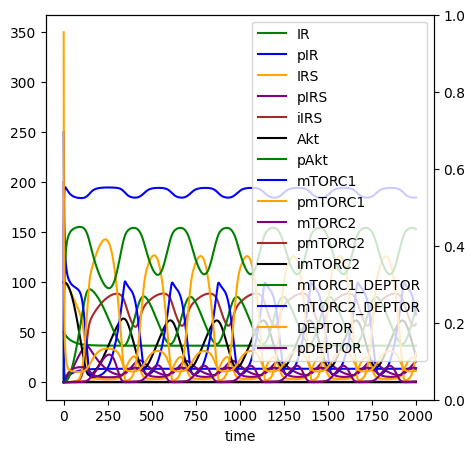

Text(0.5, 0, 'time')

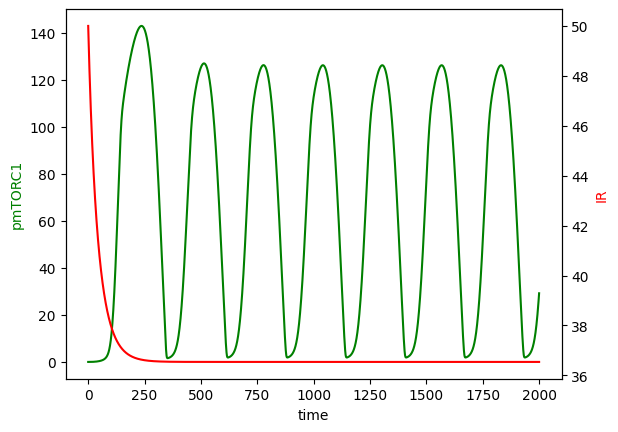

In [3]:
ts = SYSTEM.plotModel(figsize=(5,5), end_time=2000, markers=np.repeat("", 20))
for column in ts.columns:
    if not column in [INPUT_NAME, OUTPUT_NAME]:
        del ts[column]
times = ts.index/1000
plt.plot(times, ts[OUTPUT_NAME], color="green")
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(times, ts[INPUT_NAME], color="red")
ax.set_ylabel(OUTPUT_NAME, color="green")
ax2.set_ylabel(INPUT_NAME, color="red")
ax.set_xlabel("time")

In [4]:
print(SYSTEM.getValidInputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb, Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a, k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16, Km16, ks17, kd18


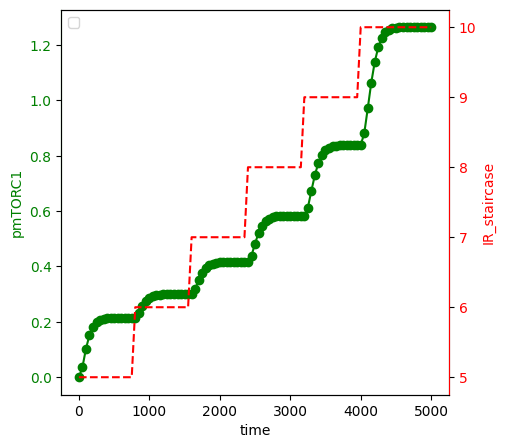

In [5]:
STAIRCASE = ctl.Staircase(initial_value=5, final_value=10, num_step=5)
BUILDER = ctl.SISOTransferFunctionBuilder(SYSTEM)
response_ts = BUILDER.makeStaircaseResponse(staircase=STAIRCASE, end_time=5000, points_per_time=10)
BUILDER.plotStaircaseResponse(response_ts, figsize=(5,5))

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

# System Identification

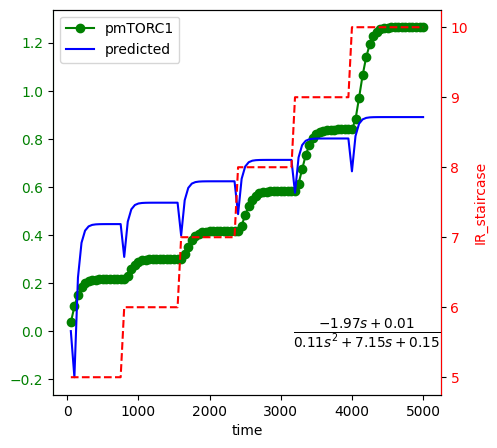

In [6]:
fitter_result = BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, staircase=STAIRCASE, 
                                            fit_start_time=0, start_time=0, end_time=5000)
BUILDER.plotFitTransferFunction(fitter_result, figsize=(5,5))

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [7]:
setpoint = 100
pass
ts, builder = SYSTEM.simulateSISOClosedLoop(kp=4.6, end_time=1000, is_steady_state=False, 
                                            setpoint=setpoint, num_point=4000, sign=-1,
                                            )
SYSTEM.plotSISOClosedLoop(ts, setpoint, markers=["", ""], figsize=(5,5))

TypeError: simulateSISOClosedLoop() got an unexpected keyword argument 'sign'

We are able to simulate the closed loop system, but it's not easy to find design parameters such that: (a) settling times are short; (b) there is not overshoot; and (c) all concentrations are non-negative.

Could the reason for the strange behavior of the feedback be that the output is not monotonic in the input?

In [ ]:
builder

# Design and Evaluation